In [2]:
%matplotlib inline
import numpy as np
from astropy.io.votable import parse_single_table
import matplotlib.pyplot as plt
import glob, os
import pandas as pd
from astropy.cosmology import WMAP9 as cosmo
import numpy_indexed as npi
import pysynphot as S
from extinction import ccm89, apply
import sfdmap
from astropy.io import fits
from scipy import spatial
from scipy import stats
from scipy.interpolate import interp1d
from scipy import interpolate
from kapteyn import kmpfit
from astropy.modeling.blackbody import blackbody_lambda
from astropy.table import Table
#plt.style.use('my')

[10.0, -1.5, 1.2710738304408123e-09, 4.6620511065161938e-08, -0.00079454355369813203, 0.24727813295736639, 3475.481475874747, 0.0]
43
2.06045866277
mpfit (potential) success: Convergence in chi-square value (1)
1


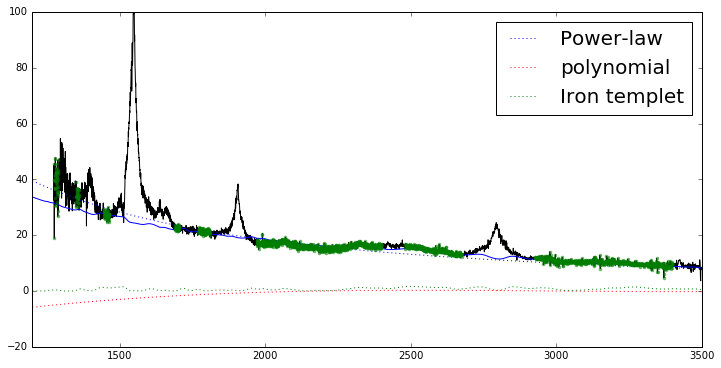

In [4]:
from kapteyn import kmpfit
path ='/Users/legolason/study/mesfit/'
def Fe_flux_mgii(xval,pp):
    yval = np.zeros_like(xval)
    fe_uv = np.genfromtxt(path+'fe_uv.txt')     #log10(rest wave) flux
    wave_Fe_mgii = 10**fe_uv[:,0]
    flux_Fe_mgii = fe_uv[:,1]*10**15
    Fe_FWHM = pp[1]
    xval_new = xval*(1.0 + pp[2])      
    
    ind = np.where((xval_new > 1200.) & (xval_new < 3500.), True,False)
    if ind.any() == True:
        if Fe_FWHM < 900.0:
            sig_conv = np.sqrt(910.0**2 - 900.0**2)/2./np.sqrt(2.*np.log(2.)) 
        else:
            sig_conv = np.sqrt(Fe_FWHM**2 - 900.0**2)/2./np.sqrt(2.*np.log(2.))   #in km/s
        #Get sigma in pixel space
        sig_pix = sig_conv/103.6     # 106.3 km/s is the dispersion for the BG92 FeII template
        khalfsz = np.round(4*sig_pix+1,0)
        xx= np.arange(0,khalfsz*2,1) - khalfsz
        kernel = np.exp(-xx**2/(2*sig_pix**2))
        kernel = kernel/np.sum(kernel)
        
        flux_Fe_conv = np.convolve(flux_Fe_mgii, kernel,'same')
        tck = interpolate.splrep(wave_Fe_mgii, flux_Fe_conv) 
        yval[ind] = pp[0]*interpolate.splev(xval_new[ind], tck)
    
    return yval


def model(p, x):
    
    y1 = p[0]*(x/3000.)**p[1]+ p[2]*(x-3000.)**3+p[3]*(x-3000.)**2+p[4]*(x-3000.) 
    y2 = Fe_flux_mgii(x, p[5:9])
    return y1+y2


def residuals(p, data):
   x, y, yerr= data                     # 'data' is a tuple given by programmer
   return (y - model(p,x))/yerr

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


# read data
data=fits.open(path+'data/inter/spec-3693-55208-0120.fits')
z=data[2].data['z']
lam=10**data[1].data['loglam']
flux=smooth(data[1].data['flux'],1)
err=1./np.sqrt(data[1].data['ivar'])
wave = lam/(1.0+z)

#fitting window
window_all = np.array([ [1150., 1170.], [1275., 1290.], [1350., 1360.], [1445., 1465.],\
                        [1690., 1705.], [1770., 1810.], [1970., 2400.], [2480., 2675.],\
                        [2925., 3400.], [3775., 3832.], [4000., 4050.], [4200., 4230.],\
                        [4435., 4700.], [5100., 5535.], [6005., 6035.], [6110., 6250.],\
                        [6800., 7000.], [7160., 7180.], [7500., 7800.], [8050., 8150.] ])



tmp_all = np.array([np.repeat(False,len(lam))]).flatten()

for jj in range(len(window_all)):
    tmp = np.where( (wave > window_all[jj,0]) & (wave < window_all[jj,1]),True,False)
    tmp_all = np.any([tmp_all, tmp],axis=0)


x=wave[tmp_all]
y=flux[tmp_all]
yerr=err[tmp_all]

pp0=[10.,-1.5,0.,0.,0.,.2,4000.,0.]
f = kmpfit.Fitter(residuals = residuals, data = (x,y,yerr),stepfactor=100000,xtol=1e-20, gtol=1e-20)
f.parinfo = [{'limits':(0.,10.**10)},{'limits':(-5.,3.)},\
             None,None,None,\
     {'limits':(0.,10000)},{'limits':(1200.,10000.)},{'limits':(-0.01,0.01)}]

try:
    f.fit(params0=pp0)
except Exception, mes:
    print "Something wrong with fit: ", mes
    raise SystemExit    
    
print f.params
print f.niter
print f.rchi2_min
print f.message
print f.status

fig=plt.figure(figsize=(12,6))
plt.plot(wave,flux,color='k')
wv=np.arange(1200,3500,0.1)
#plt.plot(x,f.params[0]*(x/3000.0)**f.params[1],'k')
conti_model=f.params[0]*(wv/3000.)**f.params[1]+\
f.params[2]*(wv-3000.)**3+f.params[3]*(wv-3000.)**2+f.params[4]*(wv-3000.)+\
Fe_flux_mgii(wv,f.params[5:])

plt.plot(wv,f.params[0]*(wv/3000.)**f.params[1],'b:', label='Power-law')
plt.plot(wv,f.params[2]*(wv-3000.)**3+f.params[3]*(wv-3000.)**2+f.params[4]*(wv-3000.),'r:',label='polynomial')
plt.plot(wv,conti_model)
plt.plot(wv,Fe_flux_mgii(wv,f.params[5:]),'g:',label='Iron templet')
plt.plot(wave[tmp_all],flux[tmp_all],'g.',alpha=0.5)  # plot continuum region
plt.xlim(1200.,3500.)
plt.ylim(-20,100)
plt.legend(fontsize=20)

[1.0, -1.5, 2.8463451484879924e-08, 5.0805187195090821e-05, 0.0025841426082505643, 1.1081502947644335, 2079.7371012788371, 0.0]
57
59.4364699647
mpfit (potential) success: Convergence in chi-square value (1)
1


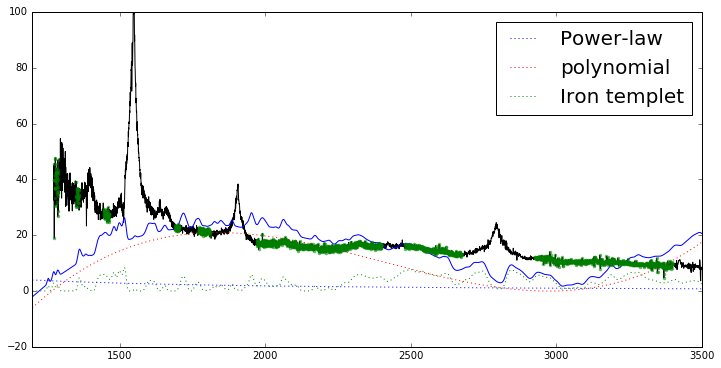

In [5]:
pp0=[1.,-1.5,0.,0.,0.,.2,4000.,0.]
f = kmpfit.Fitter(residuals = residuals, data = (x,y,yerr),stepfactor=100000,xtol=1e-20, gtol=1e-20)
f.parinfo = [{'limits':(0.,10.**10)},{'limits':(-5.,3.)},\
             None,None,None,\
     {'limits':(0.,10000)},{'limits':(1200.,10000.)},{'limits':(-0.01,0.01)}]

try:
    f.fit(params0=pp0)
except Exception, mes:
    print "Something wrong with fit: ", mes
    raise SystemExit    
    
print f.params
print f.niter
print f.rchi2_min
print f.message
print f.status

fig=plt.figure(figsize=(12,6))
plt.plot(wave,flux,color='k')
wv=np.arange(1200,3500,0.1)
#plt.plot(x,f.params[0]*(x/3000.0)**f.params[1],'k')
conti_model=f.params[0]*(wv/3000.)**f.params[1]+\
f.params[2]*(wv-3000.)**3+f.params[3]*(wv-3000.)**2+f.params[4]*(wv-3000.)+\
Fe_flux_mgii(wv,f.params[5:])

plt.plot(wv,f.params[0]*(wv/3000.)**f.params[1],'b:', label='Power-law')
plt.plot(wv,f.params[2]*(wv-3000.)**3+f.params[3]*(wv-3000.)**2+f.params[4]*(wv-3000.),'r:',label='polynomial')
plt.plot(wv,conti_model)
plt.plot(wv,Fe_flux_mgii(wv,f.params[5:]),'g:',label='Iron templet')
plt.plot(wave[tmp_all],flux[tmp_all],'g.',alpha=0.5)  # plot continuum region
plt.xlim(1200.,3500.)
plt.ylim(-20,100)
plt.legend(fontsize=20)